In [1]:
import torchvision

In [2]:
test_dataset = torchvision.datasets.MNIST('./data', train=False, download=True)

In [3]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): None
    Target Transforms (if any): None

In [273]:
import numpy as np

In [274]:
trans = torchvision.transforms.ToTensor

In [275]:
from matplotlib import pyplot as plt
%matplotlib inline

In [566]:
def collate_fn(batch):

    # Puts each data field into a tensor with outer dimension batch size
    assert isinstance(batch[0], tuple)
    trans = torchvision.transforms.ToTensor()
    batch_size = len(batch)
    
    num_total_points = 784
    num_context = 10 # half of total points
    
    context_x, context_y, target_x, target_y = list(), list(), list(), list()
    
    for d, _ in batch:
        d = trans(d)
        total_idx = range(784)
        total_idx = list(map(lambda x: (x//28, x%28), total_idx))
        c_idx = np.random.choice(range(784), num_total_points, replace=False)
        c_idx = list(map(lambda x: (x//28, x%28), c_idx))
        c_idx = c_idx[:num_context]
        c_x, c_y, total_x, total_y = list(), list(), list(), list()
        for idx in c_idx:
            c_y.append(d[:, idx[0], idx[1]])
            c_x.append((idx[0] / 27., idx[1] / 27.))
        for idx in total_idx:
            total_y.append(d[:, idx[0], idx[1]])
            total_x.append((idx[0] / 27., idx[1] / 27.))
        c_x, c_y, total_x, total_y = list(map(lambda x: t.FloatTensor(x), (c_x, c_y, total_x, total_y)))
        context_x.append(c_x)
        context_y.append(c_y)
        target_x.append(total_x)
        target_y.append(total_y)
        
        
    context_x = t.stack(context_x, dim=0)
    context_y = t.stack(context_y, dim=0).unsqueeze(-1)
    target_x = t.stack(target_x, dim=0)
    target_y = t.stack(target_y, dim=0).unsqueeze(-1)
    
    return context_x, context_y, target_x, target_y

In [567]:
from torch.utils.data import DataLoader
import torch as t

In [568]:
dloader = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn, shuffle=False)

In [436]:
from network import LatentModel

In [437]:
model = LatentModel(128)

In [438]:
model.train(False)

LatentModel(
  (latent_encoder): LatentEncoder(
    (input_projection): Linear(
      (linear_layer): Linear(in_features=3, out_features=128, bias=True)
    )
    (self_attentions): ModuleList(
      (0): Attention(
        (key): Linear(
          (linear_layer): Linear(in_features=128, out_features=128, bias=False)
        )
        (value): Linear(
          (linear_layer): Linear(in_features=128, out_features=128, bias=False)
        )
        (query): Linear(
          (linear_layer): Linear(in_features=128, out_features=128, bias=False)
        )
        (multihead): MultiheadAttention(
          (attn_dropout): Dropout(p=0.1)
        )
        (residual_dropout): Dropout(p=0.1)
        (final_linear): Linear(
          (linear_layer): Linear(in_features=256, out_features=128, bias=True)
        )
        (layer_norm): LayerNorm(torch.Size([128]), eps=1e-05, elementwise_affine=True)
      )
      (1): Attention(
        (key): Linear(
          (linear_layer): Linear(in_features=

In [451]:
state_dict = t.load('./checkpoint/checkpoint_50.pth.tar')

In [452]:
model.load_state_dict(state_dict=state_dict['model'])

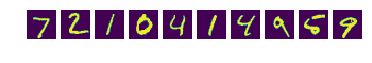

In [570]:
fig = plt.figure()
# fig1 = plt.figure()
model.train(False)
for i, d in enumerate(dloader):
    context_x, context_y, target_x, target_y = d
    pred_y, _, _ = model(context_x, context_y, target_x, None) # Test
    
    fig.add_subplot(1,10,i+1)

    plt.axis('off')
    plt.imshow(t.sigmoid(target_y).squeeze(0).view(-1,28).detach().numpy())
#     plt.imshow(t.sigmoid(target_y).squeeze(0).view(-1,28))
#     plt.imshow(pred_y.squeeze(0).view(28,28).detach().numpy())
    if i == 9:
        
        break

plt.savefig('./results/original.png', bbox_inches='tight')